# Explanation

Segmentations into gm, wm and csf regions are available from a high resolution image (144, 192, 192), saved as .nii files:
 - Segmentations/magnitude_resamToCsi_bet_pve_0.nii (this is gm)
 - Segmentations/magnitude_resamToCsi_bet_pve_1.nii (this is wm)
 - Segmentations/magnitude_resamToCsi_bet_pve_2.nii (this is csf)

I want to interpolate that to the grid used for the DMI Data of shape (22, 22, 21). The correct physical positions of the voxels
in either case are saved in the affine matrix of pve_i.nii files, or the mask in .nii format of the (22, 22, 21) grid. nilearn has 
an interpolation that directly takes into account the correct physical spacings to ensure appropriate results.

In [1]:
Subject_data = 'Tumor_1' # this is the only variable you need to set to determine the output files name

# Load all necessary data and interpolate to smaller grid

Values are clipped at 0 and 1 to ensure physical values. With interpolation it can sometimes overshoot a little bit, clipping increases accuracy.

In [2]:
import nibabel as nib
import numpy as np
from nilearn.image import resample_to_img

# Labels und Dateivorlagen
labels = ["gm", "wm", "csf"]
input_template = "Segmentations/magnitude_resamToCsi_bet_pve_{}.nii"

# --------------------------
# 1) High-Res Stack
# --------------------------
arrays_high = []
for i, label in enumerate(labels):
    hi_img = nib.load(input_template.format(i))
    data_hi = hi_img.get_fdata()           # shape: (144,192,192)
    arrays_high.append(data_hi)

stacked_high = np.stack(arrays_high, axis=-1)  # shape: (144,192,192,3)
print("High-Res stack shape:", stacked_high.shape)

# --------------------------
# 2) Low-Res Stack
# --------------------------
# Referenzbild mit Zielraster (22×22×21)
lo_img = nib.load("mask.nii")
arrays_low = []

for i, label in enumerate(labels):
    hi_img = nib.load(input_template.format(i))
    hi2lo = resample_to_img(hi_img, lo_img, interpolation="continuous")
    data_low = hi2lo.get_fdata()           # shape: (22,22,21)
    arrays_low.append(data_low)

stacked_low = np.stack(arrays_low, axis=-1)    # shape: (22,22,21,3)
print("Low-Res stack shape:", stacked_low.shape)

# --------------------------
# 3) Maske laden (falls benötigt)
# --------------------------
mask_img = nib.load("mask.nii")
mask = mask_img.get_fdata()           # shape: (22,22,21)

mask_csi = np.load(f'../datasets/{Subject_data}/mask.npy')  # falls vorhanden
print("Mask shape:", mask.shape, "CSI-Mask shape:", mask_csi.shape)

# --------------------------
# 4) Clamp PVE-Werte auf [0,1]
# --------------------------
def clamp01(pve_stack, name):
    mins = pve_stack.min(axis=(0,1,2))
    maxs = pve_stack.max(axis=(0,1,2))
    n_lt0 = (pve_stack < 0).sum()
    n_gt1 = (pve_stack > 1).sum()
    print(f"{name}: before clamp  min {mins}  max {maxs}  #<0 {n_lt0}  #>1 {n_gt1}")
    np.clip(pve_stack, 0.0, 1.0, out=pve_stack)
    mins = pve_stack.min(axis=(0,1,2))
    maxs = pve_stack.max(axis=(0,1,2))
    print(f"{name}: after clamp   min {mins}  max {maxs}")

clamp01(stacked_high, "high-res PVE")
clamp01(stacked_low,  "low-res PVE")

# --------------------------
# 5) Entpacken wie gehabt
# --------------------------
gm, wm, csf = stacked_high[...,0], stacked_high[...,1], stacked_high[...,2]



High-Res stack shape: (144, 192, 192, 3)


/tmp/ipykernel_1010393/1495246417.py:30: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hi2lo = resample_to_img(hi_img, lo_img, interpolation="continuous")
/home/hostuser/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/tmp/ipykernel_1010393/1495246417.py:30: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hi2lo = resample_to_img(hi_img, lo_img, interpolation="continuous")
/home/hostuser/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this funct

Low-Res stack shape: (22, 22, 21, 3)
Mask shape: (22, 22, 21) CSI-Mask shape: (22, 22, 21)
high-res PVE: before clamp  min [0. 0. 0.]  max [1. 1. 1.]  #<0 0  #>1 0
high-res PVE: after clamp   min [0. 0. 0.]  max [1. 1. 1.]
low-res PVE: before clamp  min [-0.34552151 -0.21433334 -0.1810362 ]  max [1.26263762 1.16544676 1.15673459]  #<0 11714  #>1 594
low-res PVE: after clamp   min [ 0. -0.  0.]  max [1. 1. 1.]


# Visualize sum of wm, gm, csf and compare to mask

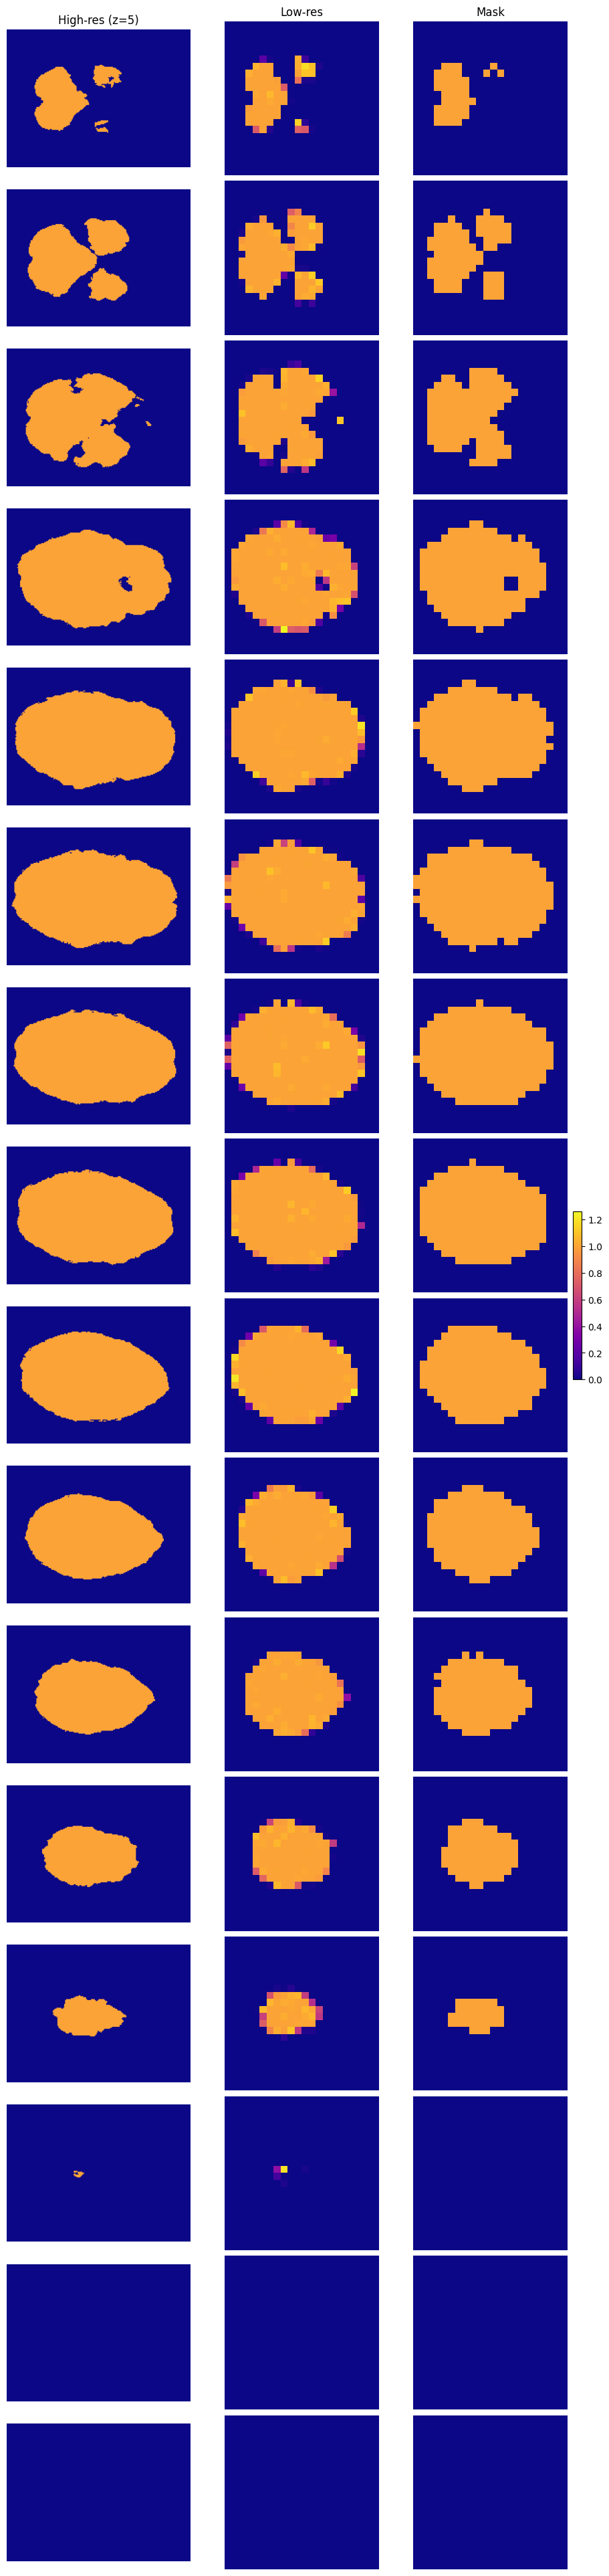

In [3]:
import matplotlib.pyplot as plt
import numpy as np

z_start, z_end = 5, 20
n_slices = z_end - z_start + 1

# Alle relevanten Daten sammeln für gemeinsame Skala
all_vals = []

for z in range(z_start, z_end + 1):
    z_large = int(np.ceil(z * 192 / 21))
    msk = mask[..., z]
    hi = np.abs((csf + wm + gm)[..., z_large])
    lo = np.abs((stacked_low[..., 0] + stacked_low[..., 1] + stacked_low[..., 2]))[..., z]
    all_vals.extend([hi, lo, msk])

# Gemeinsame Skala berechnen
vmin = min(np.min(s) for s in all_vals)
vmax = max(np.max(s) for s in all_vals)

# Plot
fig, axes = plt.subplots(nrows=n_slices, ncols=3, figsize=(9, 2.4 * n_slices), constrained_layout=True)

for row, z in enumerate(range(z_start, z_end + 1)):
    z_large = int(np.ceil(z * 192 / 21))
    slice_hi = np.abs((csf + wm + gm)[..., z_large])
    slice_mask = mask[..., z]
    slice_lo = np.abs((stacked_low[..., 0] + stacked_low[..., 1] + stacked_low[..., 2]))[..., z]#*slice_mask
    
    im0 = axes[row, 0].imshow(slice_hi, cmap='plasma', vmin=vmin, vmax=vmax)
    im1 = axes[row, 1].imshow(slice_lo, cmap='plasma', vmin=vmin, vmax=vmax)
    im2 = axes[row, 2].imshow(slice_mask, cmap='plasma', vmin=vmin, vmax=vmax)

    axes[row, 0].set_title(f'High-res (z={z})' if row == 0 else '')
    axes[row, 1].set_title('Low-res' if row == 0 else '')
    axes[row, 2].set_title('Mask' if row == 0 else '')

    for ax in axes[row]:
        ax.axis('off')

# Nur eine Colorbar für alle
fig.colorbar(im0, ax=axes, fraction=0.015, pad=0.01)

plt.show()

# Invert axes to ensure orientation matches the CombinedCSI.mat orientation (saved in mask.npy)

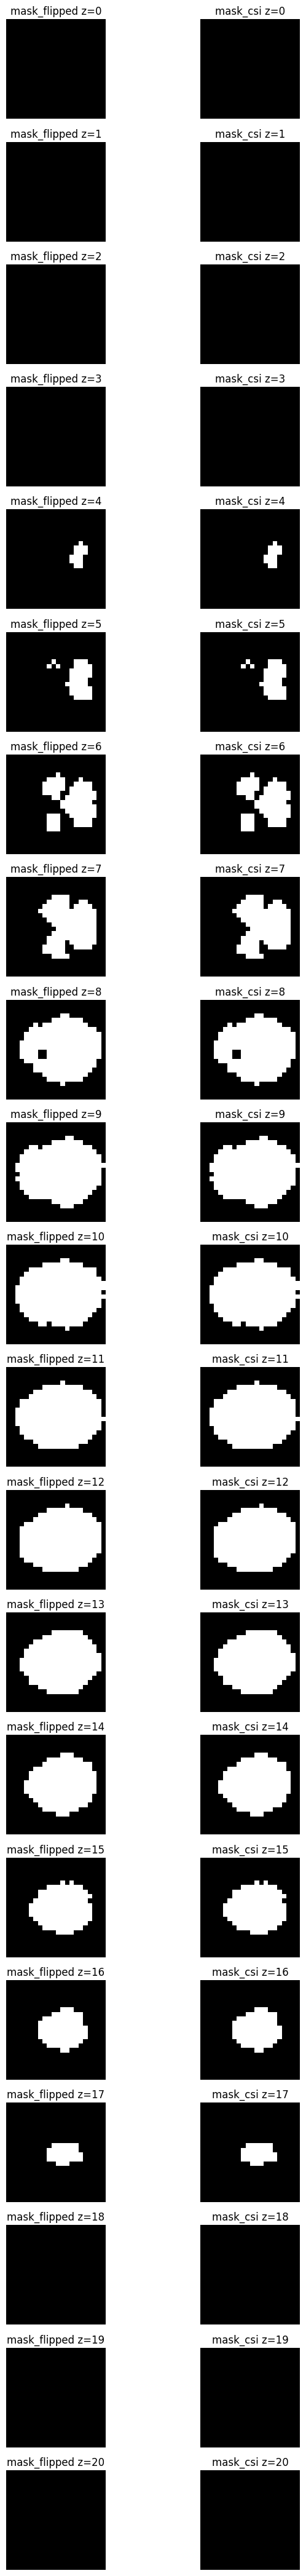

In [4]:
# invertiere die ersten drei Achsen (x, y, z)
stacked_low_flipped = stacked_low[::-1, ::-1, :, :]  # 4D: letzte Achse bleibt gleich
stacked_high_flipped = stacked_high[::-1, ::-1, :, :]  # 4D: letzte Achse bleibt gleich
mask_flipped = mask[::-1, ::-1, :]                   # 3D-Maske

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=21, ncols=2, figsize=(8, 42))  # 2 Spalten, 21 Zeilen

for z in range(21):
    # Maske 1
    axes[z, 0].imshow(mask_flipped[:, :, z], cmap='gray', origin='lower')
    axes[z, 0].set_title(f"mask_flipped z={z}")
    axes[z, 0].axis('off')

    # Maske 2
    axes[z, 1].imshow(mask_csi[:, :, z], cmap='gray', origin='lower')
    axes[z, 1].set_title(f"mask_csi z={z}")
    axes[z, 1].axis('off')

plt.tight_layout()
plt.show()


# Mask consistently and make final comparison

Note that the mask_csi for CombinedCSI.mat was very "generous" it cut away too much. For the segmentation in the final step I cut away everything outside 
the strict mask_csi to make sure that outside this mask there is no gm, wm, csf (the strict mask is used by lcmodel)

In [5]:
stacked_high_flipped.shape

(144, 192, 192, 3)

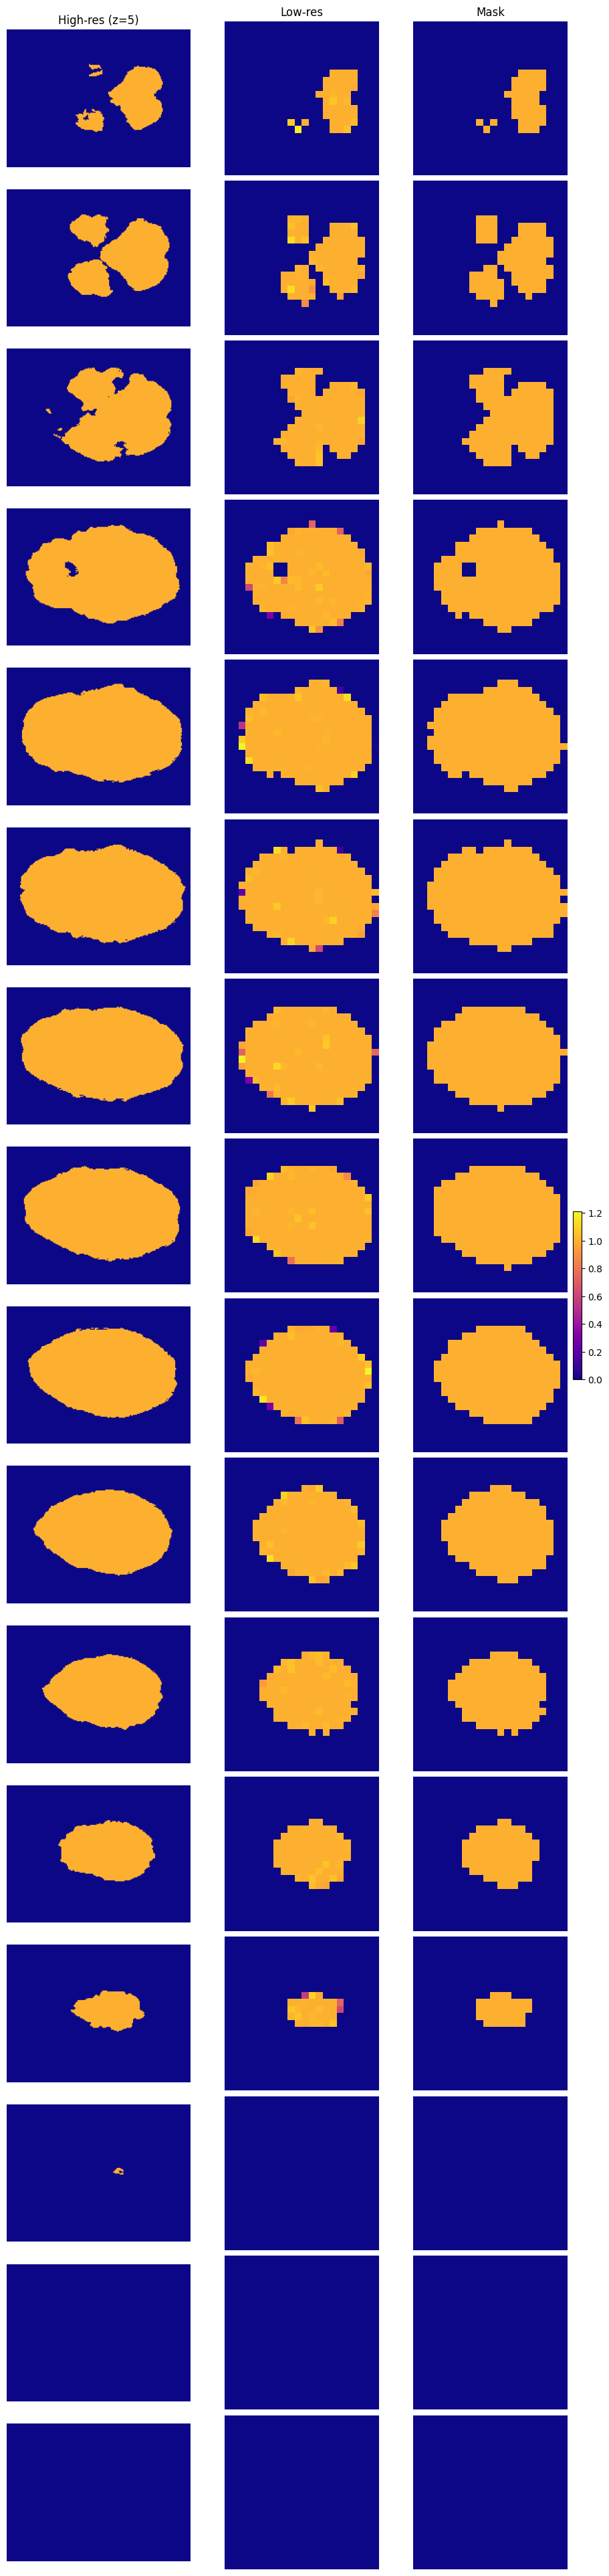

In [6]:
stacked_low_flipped_masked = stacked_low_flipped*mask_flipped[..., np.newaxis]

import matplotlib.pyplot as plt
import numpy as np

z_start, z_end = 5, 20
n_slices = z_end - z_start + 1

# Alle relevanten Daten sammeln für gemeinsame Skala
all_vals = []

for z in range(z_start, z_end + 1):
    z_large = int(np.ceil(z * 192 / 21))
    msk = mask_csi[..., z]
    hi = np.abs((np.sum(stacked_high_flipped, axis=-1))[..., z_large])
    lo = np.abs((np.sum(stacked_low_flipped_masked, axis=-1)))[..., z]
    all_vals.extend([hi, lo, msk])

# Gemeinsame Skala berechnen
vmin = min(np.min(s) for s in all_vals)
vmax = max(np.max(s) for s in all_vals)

# Plot
fig, axes = plt.subplots(nrows=n_slices, ncols=3, figsize=(9, 2.4 * n_slices), constrained_layout=True)

for row, z in enumerate(range(z_start, z_end + 1)):
    z_large = int(np.ceil(z * 192 / 21))
    slice_hi = np.abs((np.sum(stacked_high_flipped, axis=-1))[..., z_large])
    slice_mask = mask_csi[..., z]
    slice_lo = np.abs((np.sum(stacked_low_flipped_masked, axis=-1)))[..., z]#*slice_mask
    
    im0 = axes[row, 0].imshow(slice_hi, cmap='plasma', vmin=vmin, vmax=vmax)
    im1 = axes[row, 1].imshow(slice_lo, cmap='plasma', vmin=vmin, vmax=vmax)
    im2 = axes[row, 2].imshow(slice_mask, cmap='plasma', vmin=vmin, vmax=vmax)

    axes[row, 0].set_title(f'High-res (z={z})' if row == 0 else '')
    axes[row, 1].set_title('Low-res' if row == 0 else '')
    axes[row, 2].set_title('Mask' if row == 0 else '')

    for ax in axes[row]:
        ax.axis('off')

# Nur eine Colorbar für alle
fig.colorbar(im0, ax=axes, fraction=0.015, pad=0.01)

plt.show()

# Save interpolated and correctly oriented segmentations

In [ ]:
#np.save(f'../datasets/{Subject_data}/gm_wm_csf_segmentation.npy', stacked_low_flipped_masked)